# Wholesale Price Analysis (Annex 3)

## 1. Objectives
This notebook focuses on **Cost Intelligence**. We analyze the wholesale price data (`annex3.csv`) to track market fluctuations and protect margins.

**Key Goals:**
- **Data Engineering**: Handling missing price data (interpolation) and validating positive costs.
- **Volatility Tracking**: Interactive dashboards to identify high-risk volatile items.
- **Inflation Monitoring**: Visualize overall market cost trends.
- **Cost Distribution**: Understanding the spread of item costs.

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

## 2. Data Loading & Engineering

In [12]:
file_path = 'annex3.csv'
df = pd.read_csv(file_path)

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Deep Cleaning
# 1. Sort by Date and Item to ensure logical order for interpolation
df = df.sort_values(by=['Item Code', 'Date'])

# 2. Handle Missing Prices: Forward fill then Backward fill (assume price stability)
missing_before = df['Wholesale Price (RMB/kg)'].isnull().sum()
if missing_before > 0:
    print(f"Found {missing_before} missing prices. Interpolating...")
    df['Wholesale Price (RMB/kg)'] = df.groupby('Item Code')['Wholesale Price (RMB/kg)'].fillna(method='ffill').fillna(method='bfill')

# 3. Validation: Remove negative or zero prices (unrealistic for wholesale)
invalid_prices = df[df['Wholesale Price (RMB/kg)'] <= 0]
if not invalid_prices.empty:
    print(f"Warning: {len(invalid_prices)} entries have non-positive prices. Dropping them.")
    df = df.drop(invalid_prices.index)

print("Price data cleaned.")

# EXPORT CLEANED DATA
cleaned_file_path = 'annex3_cleaned.csv'
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned price data exported to {cleaned_file_path}")
df.head()

Price data cleaned.
Cleaned price data exported to annex3_cleaned.csv


,Date,Item Code,Wholesale Price (RMB/kg)
5011,2020-10-30,102900005115168,3.0
5059,2020-10-31,102900005115168,3.0
5105,2020-11-01,102900005115168,3.0
6602,2020-12-04,102900005115168,1.6
10855,2021-03-03,102900005115168,1.6


## 3. Interactive Price Analytics

### 3.1 Market Cost Trend (Overall)
Is the market getting more expensive? This chart averages all item prices per day.

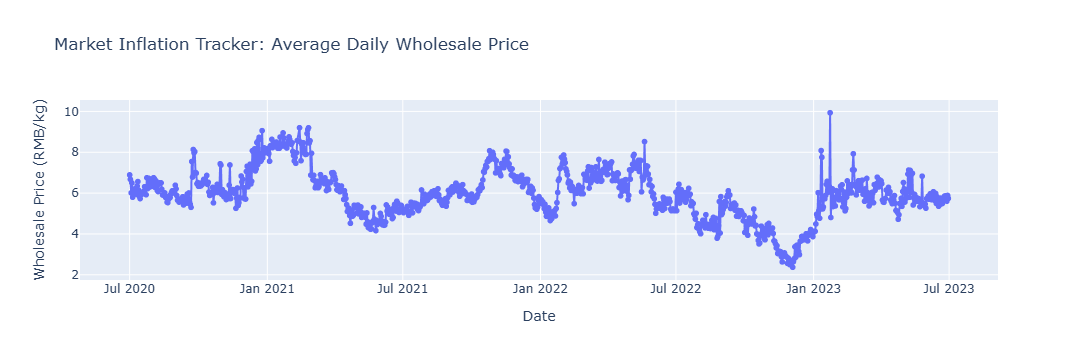

In [13]:
daily_avg_price = df.groupby('Date')['Wholesale Price (RMB/kg)'].mean().reset_index()

fig = px.line(daily_avg_price, x='Date', y='Wholesale Price (RMB/kg)', 
              title='Market Inflation Tracker: Average Daily Wholesale Price',
              markers=True)
fig.update_layout(hovermode="x unified")
fig.show()

### 3.2 Volatility Radar
Which specific items are most unstable? We calculate the Standard Deviation of price for each item.

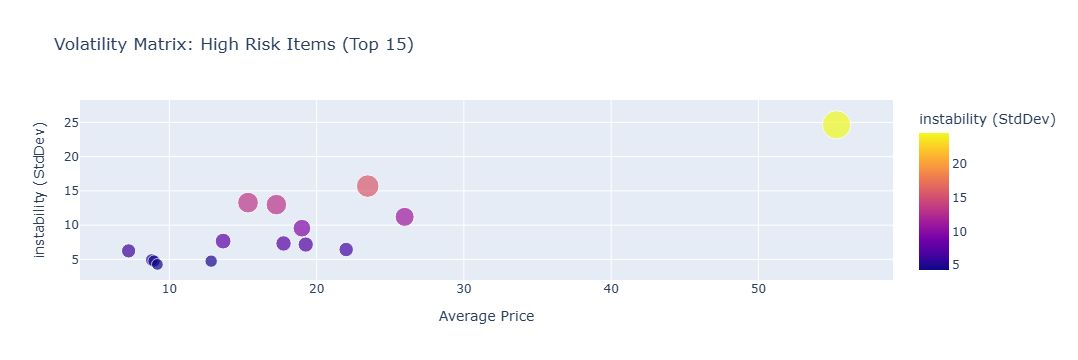

In [14]:
# Calculate volatility metrics
volatility = df.groupby('Item Code')['Wholesale Price (RMB/kg)'].agg(['std', 'mean']).reset_index()
volatility.columns = ['Item Code', 'Price Volatility (StdDev)', 'Average Price']
volatility = volatility.sort_values(by='Price Volatility (StdDev)', ascending=False).head(15)
volatility['Item Code'] = volatility['Item Code'].astype(str)

fig = px.scatter(volatility, x='Average Price', y='Price Volatility (StdDev)', 
                 size='Price Volatility (StdDev)', color='Price Volatility (StdDev)',
                 hover_name='Item Code',
                 title='Volatility Matrix: High Risk Items (Top 15)',
                 labels={'Price Volatility (StdDev)': ' instability (StdDev)'})
fig.show()

### 3.3 Deep Dive: Price History of Most Volatile Item
In-depth look at the single most unstable item.

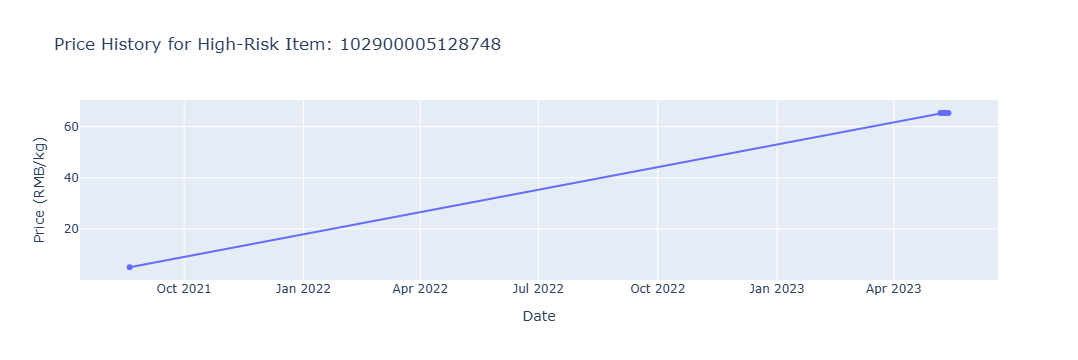

In [15]:
most_volatile_item = volatility.iloc[0]['Item Code']
item_data = df[df['Item Code'].astype(str) == most_volatile_item]

fig = go.Figure()
fig.add_trace(go.Scatter(x=item_data['Date'], y=item_data['Wholesale Price (RMB/kg)'],
                    mode='lines+markers',
                    name='Wholesale Price'))
fig.update_layout(title=f'Price History for High-Risk Item: {most_volatile_item}',
                  xaxis_title='Date',
                  yaxis_title='Price (RMB/kg)')
fig.show()

## 4. Strategic Procurement Insights

### 📊 Cost Intelligence
- **Inflation Gauge**: Chart 3.1 allows you to separate internal inefficiencies from external market forces. If the line is trending up, your suppliers are charging more market-wide.
- **Risk Identification**: The Bubble Chart (3.2) isolates "Problem Children". Items in the top-right are expensive AND unstable—the worst combination for planning.

### 🚀 Actionable Recommendations
1.  **Contract Negotiation**:
    -   *Insight*: Identify the top 3 items in the Volatility Matrix (Chart 3.2).
    -   *Action*: Negotiate fixed-price contracts for these specifica items to shield the business from the wild swings seen in Chart 3.3.

2.  **Dynamic Pricing Strategy**:
    -   *Insight*: For items with high volatility that cannot be fixed-contracted.
    -   *Action*: Link retail prices dynamically to these wholesale costs. If wholesale spikes 20%, retail should automatically adjust to preserve margin, rather than waiting for a manual update.

3.  **Inventory Buffering**:
    -   *Insight*: When Chart 3.3 shows a 'dip', it's a buying signal.
    -   *Action*: Increase safety stock when prices hit the lower bound of their historical range (Buy Low), so you can avoid purchasing during the inevitable peaks.